In [1]:
import cmocean as cmo
import datetime as dt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sc
import scipy.io as sio
from matplotlib.gridspec import GridSpec
import seawater as sw
import gsw as gsw
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_7771/3505783052.py:11: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
def read_bin(file, shape, k=0, dtype='>f4'):
    '''Read the whole binary file
    shape:: tuple with the final shape of the 
            data in order (nt,ny,nx,nz) for 
            3D + time fields or (nt,ny,nx) for 
            2D + time fields.
    dtype:: string with any accepted python format. 
            Most common are '>f8' equivalent to real*8, 
            ieee-b and '>f4' equivalent to real*4, ieee-b.
    RETURNS
    Numpy array of data of shape "shape".
    '''
#    with open(file, 'r') as f:
#        cc = np.fromfile(f,dtype=dtype)
#   return(np.reshape(cc, shape, order='C'))
    shape_arr = np.array(shape)
    nnn = shape_arr.prod()
    WORDLENGTH = 4 # default word length
    with open(file, "rb") as f:
        if k=='all': # Load the whole thing
            cc=np.fromfile(f,dtype=dtype)
        else:
            offs=nnn*k*WORDLENGTH
            #f.seek(nnn*k*WORDLENGTH)
            cc=np.fromfile(f,offset=offs,count=nnn,dtype=dtype)
    return(np.reshape(cc, shape, order='C'))


def load_bat(file):
    '''Load X, Y and Z arrays from mat file'''
    bathy = sio.loadmat(bathy_file)
    return(bathy['XC'][:], bathy['YC'][:], bathy['RC'][:])

def load_depth(file):
    '''Load depth array from mat file'''
    bathy = sio.loadmat(bathy_file)
    return(bathy['Depth'][:])

def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
    return day + dayfrac

def plot_fld(ax,XC,YC,fld_slice,date_str, vmin=-0.15, vmax=0.15, cmap=cmo.cm.balance,clab=r'Free surface (m)'):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[:,0],YC[0,:],fld_slice, cmap=cmap, vmin=vmin, vmax=vmax)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.89, 0.125, 0.025, 0.76])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=cbar_ax, orientation='vertical', 
                      format='%1.2f', label=clab)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    return(ax)

def plot_vel(ax,XC,YC,v_slice,date_str, vmin=-0.8, vmax=0.8):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[:,0],YC[0,:],v_slice, cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(pc, ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    return(ax)

def plot_fld_anim(ax,XC,YC,eta_slice,date_str,vmin=-0.15, vmax=0.15,cmap=cmo.cm.balance,clab=r'Free surface (m)'):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[:,0],YC[0,:],eta_slice, cmap=cmap, vmin=vmin, vmax=vmax)
    cmap = cmap
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.89, 0.125, 0.022, 0.755])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=cbar_ax, orientation='vertical', 
                      format='%1.2f', label=clab)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    width = XC[-1,0]-XC[-59,0]
    height = YC[0,59]-YC[0,0]
    rect = patches.Rectangle((XC[-60,0],YC[0,0]),width,height,linewidth=2,edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    return(ax)

def plot_fld_zoom(ax,XC,YC,eta_slice,date_str,vmin=-0.15,vmax=0.15,cmap=cmo.cm.balance):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[-60:,0],YC[0,:60],eta_slice[:60,-60:], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    width = XC[-1,0]-XC[-60,0]
    height = YC[0,60]-YC[0,0]
    rect = patches.Rectangle((XC[-60,0],YC[0,0]),width,height,linewidth=3,edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    ax.set_xlim(XC[-60,0],XC[-1,0],)
    ax.set_ylim(YC[0,0],YC[0,60],)
    
    return(ax)

def calc_N(density, depth, RhoRef):
    '''Calculate buoyancy frequency from density and depth vectors'''
    g = 9.81
    N = ((g/RhoRef)*(-(density[2:]-density[:-2])/(depth[2:]-depth[:-2])))**0.5 
    return(N, depth[1:-1])



In [8]:
pwd

'/Users/estebancruz/MITgcm/verification/BayIW/input/STATE'

In [12]:
bathy_file = '/Users/estebancruz/MITgcm/verification/BayIW/input/STATE/grid.mat'
fmt_file = '/Users/estebancruz/MITgcm/verification/BayIW/input/STATE/FMT.mat'

fpath = '/Users/estebancruz/MITgcm/verification/BayIW/input/STATE/'
dpath = '/Users/estebancruz/MITgcm/verification/BayIW/input/STATE/'

In [13]:
XC, YC, ZC = load_bat(bathy_file)
depth = load_depth(bathy_file)
nxc = len(XC[:])
nyc = len(YC[0,:]) 
nzc = len(ZC[:])
nt = 4656

In [14]:
# Read date strings
date_strs = read_bin(dpath+'TIME_CCS_2007_2023.bin', (nt), k=0)

tt1 = 32+(365*11)
# Read T
T1 = read_bin(dpath+'T_MIT_CCS_2007_2023_fulldomain.bin', (nzc,nyc,nxc), k=tt1)
# Read S
#S1 = read_bin(dpath+'S_MIT_CCS_2007_2023_fulldomain.bin', (nzc,nyc,nxc), k=tt1)

tt2 = (31*7)+(365*11)
# Read T
T2 = read_bin(dpath+'T_MIT_CCS_2007_2023_fulldomain.bin', (nzc,nyc,nxc), k=tt2)
# Read S
#S2 = read_bin(dpath+'S_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt2)

In [15]:
print(YC)


[[27.23125076 27.29375076 27.35625076 ... 39.79375076 39.85625076
  39.91875076]
 [27.23125076 27.29375076 27.35625076 ... 39.79375076 39.85625076
  39.91875076]
 [27.23125076 27.29375076 27.35625076 ... 39.79375076 39.85625076
  39.91875076]
 ...
 [27.23125076 27.29375076 27.35625076 ... 39.79375076 39.85625076
  39.91875076]
 [27.23125076 27.29375076 27.35625076 ... 39.79375076 39.85625076
  39.91875076]
 [27.23125076 27.29375076 27.35625076 ... 39.79375076 39.85625076
  39.91875076]]


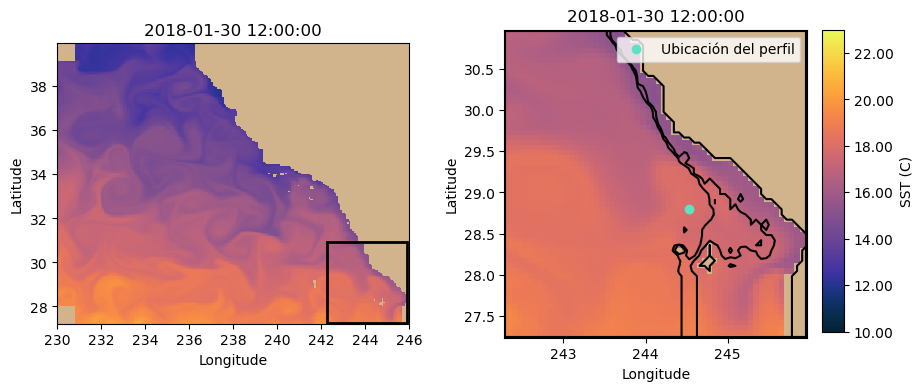

Coordenadas perfil: Latitud  28.793750762939453 , Longitud  244.53125


In [16]:
# Distribución de la temperatura en la superficie en Enerno (Invierno)
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4)) 

plot_fld_anim(ax0,XC,YC,T1[0,:,:],date_strs[tt1],vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='SST (C)')
plot_fld_zoom(ax1,XC,YC,T1[0,:,:],date_strs[tt1],vmin=10,vmax=23,cmap=cmo.cm.thermal)
cn = ax1.contour(XC,YC,depth, levels=[0,100,200], colors='k')
ax1.plot(XC[232,25],YC[232,25],'ko', color= '#5DE3C4', label='Ubicación del perfil')
ax1.legend()
plt.show()
print('Coordenadas perfil: Latitud ',YC[232,25],', Longitud ', XC[232,25])

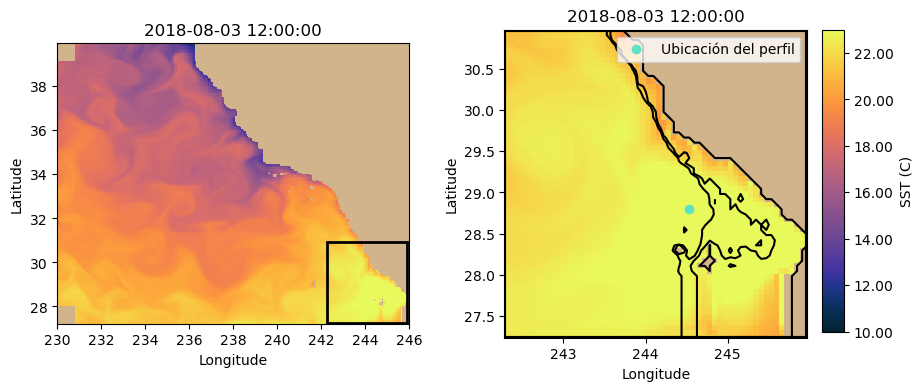

In [17]:
# Distribución de la temperatura en la superficie en Agosto (Verano)

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4)) 

plot_fld_anim(ax0,XC,YC,T2[0,:,:],date_strs[tt2],vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='SST (C)')
plot_fld_zoom(ax1,XC,YC,T2[0,:,:],date_strs[tt2],vmin=10,vmax=23,cmap=cmo.cm.thermal)
cn = ax1.contour(XC,YC,depth, levels=[0,100,200], colors='k')
ax1.plot(XC[232,25],YC[232,25],'ko', color= '#5DE3C4', label='Ubicación del perfil')
ax1.legend()

plt.show()


In [18]:

# Read S
S1 = read_bin(dpath+'S_MIT_CCS_2007_2023_fulldomain.bin', (nzc,nyc,nxc), k=tt1)
# Read S
S2 = read_bin(dpath+'S_MIT_CCS_2007_2023_fulldomain.bin', (nzc,nyc,nxc), k=tt2)

T, S and density profiles along 28.5 N above 200 m


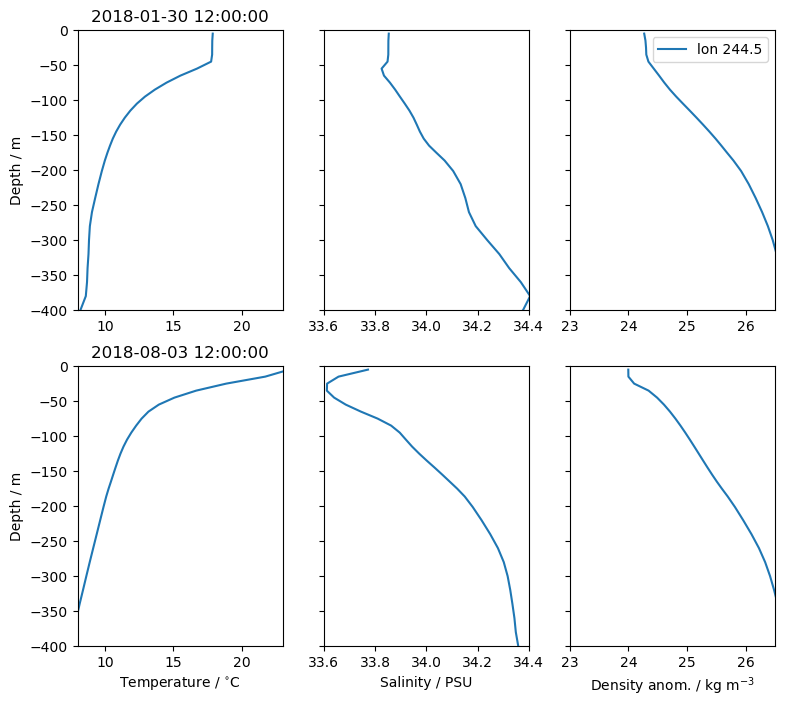

In [19]:
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3, figsize=(9,8), sharey=True) 
sns.set_palette("rocket_r",13)

ax0.plot(T1[:,25,232],ZC[:],label='lon %1.1f'%XC[232,25])
ax3.plot(T2[:,25,232],ZC[:],label='lon %1.1f'%XC[232,25])

ax1.plot(S1[:,25,232],ZC[:],label='lon %1.1f'%XC[232,25])
ax4.plot(S2[:,25,232],ZC[:],label='lon %1.1f'%XC[232,25])

dens1 = sw.pden(np.squeeze(S1[:,25,23]),np.squeeze(T1[:,25,23]),np.squeeze(ZC[:]))
ax2.plot(dens1-1000,ZC[:],label='lon %1.1f'%XC[232,25])

dens2 = sw.pden(np.squeeze(S2[:,25,23]),np.squeeze(T2[:,25,23]),np.squeeze(ZC[:]))
ax5.plot(dens2-1000,ZC[:],label='lon %1.1f'%XC[232,25])

ax2.legend(bbox_to_anchor=(1,1))  
ax0.set_title(matlab2datetime(date_strs[tt1]) )
ax3.set_title(matlab2datetime(date_strs[tt2]))
ax0.set_ylabel('Depth / m')
ax3.set_ylabel('Depth / m')
ax3.set_xlabel(r'Temperature / $^{\circ}$C')
ax4.set_xlabel(r'Salinity / PSU')
ax5.set_xlabel(r'Density anom. / kg m$^{-3}$')

ax0.set_xlim(8,23)
ax3.set_xlim(8,23)
ax1.set_xlim(33.6,34.4)
ax4.set_xlim(33.6,34.4)
ax2.set_xlim(23,26.5)
ax5.set_xlim(23,26.5)

ax0.set_ylim(-400,0)
print('T, S and density profiles along 28.5 N above 200 m')

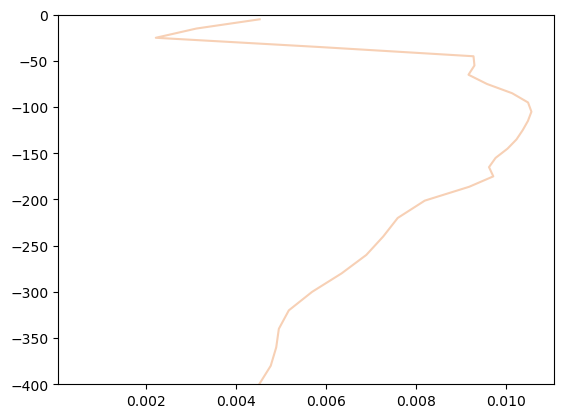

In [20]:
# Latitud del perfil (por ejemplo, 30 grados norte)
lat = 28.0

# Convertir profundidad a presión (en dbar)
# Nota: gsw.p_from_z usa profundidad como un valor negativo (hacia abajo)
pressure = gsw.p_from_z(ZC[:], lat)

N2,p_mid = gsw.stability.Nsquared(np.squeeze(S1[:,25,23]),np.squeeze(T1[:,25,23]),np.squeeze(pressure),lat=lat)
N2=np.sqrt(N2)
fig, ax = plt.subplots(1,1)
ax.plot(np.abs(N2),np.squeeze(ZC[:-1]),label='lon %1.1f'%XC[232,25])
ax.set_ylim(-400,0)
plt.show()

Text(0.5, 0, 'Density anom. / kg m$^{-3}$')

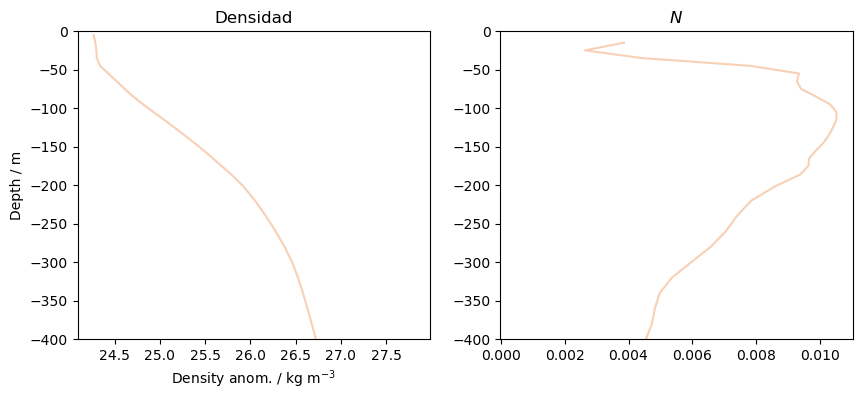

In [21]:
RhoRef = dens1[6]
T0= T1[6,25,232]
N1, depth= calc_N(dens1[:],ZC[:,0],RhoRef)
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4)) 
ax0.plot(dens1-1000,ZC[:],label='lon %1.1f'%XC[232,25])
ax1.plot(N1[:],depth[:])
ax0.set_title('Densidad')
ax1.set_title(r'$N$')
ax0.set_ylim(-400,0)
ax1.set_ylim(-400,0)
ax0.set_ylabel('Depth / m')
ax0.set_xlabel(r'Density anom. / kg m$^{-3}$')

In [22]:
N_45=N2[3]
print(N_45)

0.00585551074440867


In [23]:
RhoRef

1024.5221217934895

In [24]:
# Profundidad de referencia (usualmente la superficie, pero en este caso z_0 es -15 m)
z_0 = depth[0]


g = 9.81  # aceleración debida a la gravedad (m/s^2)

# Cálculo del perfil de densidad
rho_profile = RhoRef - (N_45**2 * RhoRef / g) * (depth - z_0)

#depth[43]= -1012.5


In [25]:
rho_profile.shape

(70,)

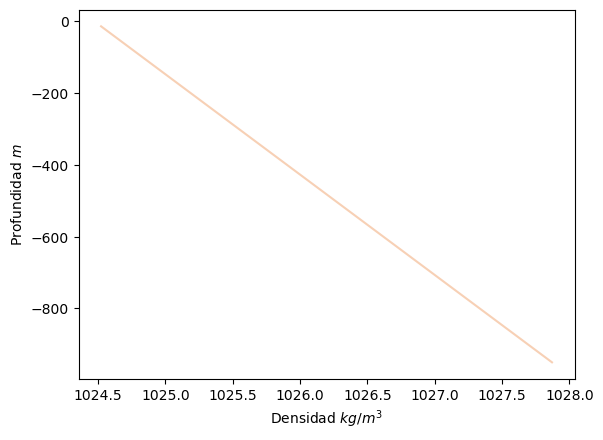

In [26]:
fig, ax = plt.subplots(1,1)
ax.plot(rho_profile[:43],depth[:43])
ax.set_ylabel(r'Profundidad $m$')
ax.set_xlabel(r'Densidad $kg/m^3$')
ax.title(r'Perfil vertical de densidad lineal con $N=$')
# Save the plot as a PNG file
file_path = "/Users/estebancruz/MITgcm/verification/BayIW/input/Perfil_rhoL.png"
plt.savefig(file_path, dpi=300)
plt.show()

In [27]:
# Constantes
alpha = 2e-4  # Coeficiente de expansión térmica volumétrica del agua de mar (aprox.)
RhoRef = 1024.5221217934895  # Densidad de referencia
TempRef = 35 # Temperatura de referencia en °C 


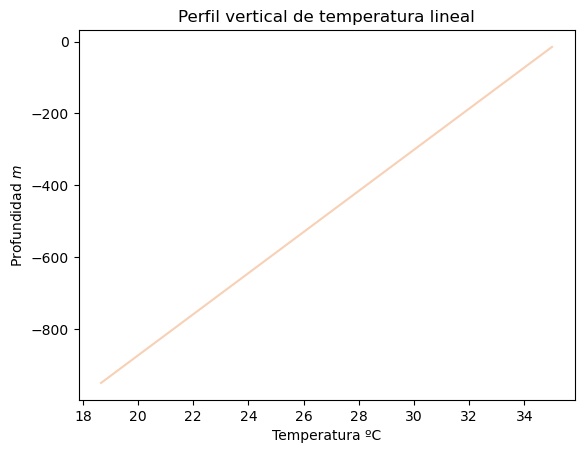

In [34]:
# Cálculo del perfil de temperatura
temperature_profile = TempRef + (RhoRef - rho_profile) / (alpha*RhoRef)
T_1000=temperature_profile[:43]
depth_1000= depth[:43]
fig, ax = plt.subplots(1,1)
ax.plot(T_1000,depth_1000)
ax.set_ylabel(r'Profundidad $m$')
ax.set_xlabel(r'Temperatura ºC')
ax.set_title('Perfil vertical de temperatura lineal')
file_path = "/Users/estebancruz/MITgcm/verification/BayIW/input/Perfil_TempL.png"
plt.savefig(file_path, dpi=300)
#ax.set_ylim(1000)
plt.show()

In [30]:
depth[43]

-1012.5

In [40]:
240/16

15.0

In [41]:
180/12

15.0

SyntaxError: invalid syntax (2206572591.py, line 1)